In [1]:
import numpy as np
import gym
from keras.models import Model
from keras.layers import Input, Dense
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ndk03/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
ENV = 'Acrobot-v1'
# CONTINUOUS = False
EPISODES = 10000
LOSS_CLIPPING = 0.2 # Only implemented clipping for the surrogate loss, paper said it was best
EPOCHS = 10
NOISE = 1.0 # Exploration noise
GAMMA = 0.99
BUFFER_SIZE = 2048
BATCH_SIZE = 256
NUM_ACTIONS = 3 #cartpole=2, acrobot = 3
NUM_STATE = 6 #cartpole =4,acrobot = 6
HIDDEN_SIZE = 128 #Cartpole 128, acrobot 256
NUM_LAYERS = 3 #cartpole = 2, #acrobot = 4
ENTROPY_LOSS = 5e-3
LR = 1e-4  # Lower lr stabilises training greatly
DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTIONS)), np.zeros((1, 1))

In [3]:
def ppo_loss(advantage, old_prediction):
    def loss(y_true, y_pred):
        prob = K.sum(y_true * y_pred, axis=-1)
        old_prob = K.sum(y_true * old_prediction, axis=-1)
        r = prob/(old_prob + 1e-10)
        return -K.mean(K.minimum(r * advantage, K.clip(r, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantage) + ENTROPY_LOSS * -(prob * K.log(prob + 1e-10)))
    return loss

In [4]:
class Agent:
    def __init__(self):
        self.critic = self.build_critic()
        self.actor = self.build_actor()
        self.env = gym.make(ENV)
        self.episode = 0
        self.observation = self.env.reset()
        self.val = False
        self.reward = []
        self.reward_over_time = []
        self.gradient_steps = 0
        self.rewards_list = []

    def build_actor(self):
        state_input = Input(shape=(NUM_STATE,))
        advantage = Input(shape=(1,))
        old_prediction = Input(shape=(NUM_ACTIONS,))
        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)
        out_actions = Dense(NUM_ACTIONS, activation='softmax', name='output')(x)
        model = Model(inputs=[state_input, advantage, old_prediction], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=LR),loss=[ppo_loss(advantage=advantage,old_prediction=old_prediction)])
        model.summary()
        return model

    def build_critic(self):
        state_input = Input(shape=(NUM_STATE,))
        x = Dense(HIDDEN_SIZE, activation='tanh')(state_input)
        for _ in range(NUM_LAYERS - 1):
            x = Dense(HIDDEN_SIZE, activation='tanh')(x)
        out_value = Dense(1)(x)
        model = Model(inputs=[state_input], outputs=[out_value])
        model.compile(optimizer=Adam(lr=LR), loss='mse')
        return model

    def reset_env(self):
        self.episode += 1
        if self.episode % 100 == 0:
            self.val = True
        else:
            self.val = False
        self.observation = self.env.reset()
        self.reward = []

    def get_action(self):
        p = self.actor.predict([self.observation.reshape(1, NUM_STATE), DUMMY_VALUE, DUMMY_ACTION])
        if self.val is False:
            action = np.random.choice(NUM_ACTIONS, p=np.nan_to_num(p[0]))
        else:
            action = np.argmax(p[0])
        action_matrix = np.zeros(NUM_ACTIONS)
        action_matrix[action] = 1
        return action, action_matrix, p

    def transform_reward(self):
        print("episode=", self.episode)
        print('Reward=',np.sum(self.reward))
        self.rewards_list.append(np.sum(self.reward))
        for j in range(len(self.reward) - 2, -1, -1):
            self.reward[j] += self.reward[j + 1] * GAMMA

    def get_batch(self):
        batch = [[], [], [], []]

        tmp_batch = [[], [], []]
        while len(batch[0]) < BUFFER_SIZE:
            action, action_matrix, predicted_action = self.get_action()
            observation, reward, done, info = self.env.step(action)
            self.reward.append(reward)
            tmp_batch[0].append(self.observation)
            tmp_batch[1].append(action_matrix)
            tmp_batch[2].append(predicted_action)
            self.observation = observation

            if done:
                self.transform_reward()
                if self.val is False:
                    for i in range(len(tmp_batch[0])):
                        obs, action, pred = tmp_batch[0][i], tmp_batch[1][i], tmp_batch[2][i]
                        r = self.reward[i]
                        batch[0].append(obs)
                        batch[1].append(action)
                        batch[2].append(pred)
                        batch[3].append(r)
                tmp_batch = [[], [], []]
                self.reset_env()
        obs, action, pred, reward = np.array(batch[0]), np.array(batch[1]), np.array(batch[2]), np.reshape(np.array(batch[3]), (len(batch[3]), 1))
        pred = np.reshape(pred, (pred.shape[0], pred.shape[2]))
        return obs, action, pred, reward

    def run(self):
        rewards_list = []
        while self.episode < EPISODES:
            obs, action, pred, reward = self.get_batch()
            obs, action, pred, reward = obs[:BUFFER_SIZE], action[:BUFFER_SIZE], pred[:BUFFER_SIZE], reward[:BUFFER_SIZE]
            old_prediction = pred
            pred_values = self.critic.predict(obs)
            rewards_list.append(np.max(reward))
            advantage = reward - pred_values
            actor_loss = self.actor.fit([obs, advantage, old_prediction], [action], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            critic_loss = self.critic.fit([obs], [reward], batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=False)
            self.gradient_steps += 1
        return self.rewards_list

In [5]:
ag = Agent()
rewards = ag.run()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 3)                 387       
Total params: 34,307
Trainable params: 34,307
Non-trainable params: 0
_________________________________________________________________

episode= 0
Reward= -282.0
episode= 1
Reward= -269.0
episode= 2
Reward= -300.0
episode= 3
Reward= -189.0
episode= 4
Rewar

episode= 241
Reward= -331.0
episode= 242
Reward= -490.0
episode= 243
Reward= -287.0
episode= 244
Reward= -320.0
episode= 245
Reward= -500.0
episode= 246
Reward= -335.0
episode= 247
Reward= -381.0
episode= 248
Reward= -375.0
episode= 249
Reward= -500.0
episode= 250
Reward= -500.0
episode= 251
Reward= -500.0
episode= 252
Reward= -500.0
episode= 253
Reward= -238.0
episode= 254
Reward= -500.0
episode= 255
Reward= -401.0
episode= 256
Reward= -344.0
episode= 257
Reward= -500.0
episode= 258
Reward= -375.0
episode= 259
Reward= -303.0
episode= 260
Reward= -355.0
episode= 261
Reward= -500.0
episode= 262
Reward= -445.0
episode= 263
Reward= -500.0
episode= 264
Reward= -464.0
episode= 265
Reward= -357.0
episode= 266
Reward= -270.0
episode= 267
Reward= -500.0
episode= 268
Reward= -500.0
episode= 269
Reward= -351.0
episode= 270
Reward= -329.0
episode= 271
Reward= -484.0
episode= 272
Reward= -434.0
episode= 273
Reward= -494.0
episode= 274
Reward= -500.0
episode= 275
Reward= -500.0
episode= 276
Reward=

episode= 535
Reward= -151.0
episode= 536
Reward= -155.0
episode= 537
Reward= -192.0
episode= 538
Reward= -124.0
episode= 539
Reward= -167.0
episode= 540
Reward= -182.0
episode= 541
Reward= -191.0
episode= 542
Reward= -156.0
episode= 543
Reward= -244.0
episode= 544
Reward= -130.0
episode= 545
Reward= -142.0
episode= 546
Reward= -155.0
episode= 547
Reward= -154.0
episode= 548
Reward= -230.0
episode= 549
Reward= -184.0
episode= 550
Reward= -157.0
episode= 551
Reward= -117.0
episode= 552
Reward= -158.0
episode= 553
Reward= -130.0
episode= 554
Reward= -200.0
episode= 555
Reward= -246.0
episode= 556
Reward= -299.0
episode= 557
Reward= -171.0
episode= 558
Reward= -227.0
episode= 559
Reward= -221.0
episode= 560
Reward= -184.0
episode= 561
Reward= -200.0
episode= 562
Reward= -248.0
episode= 563
Reward= -157.0
episode= 564
Reward= -204.0
episode= 565
Reward= -195.0
episode= 566
Reward= -141.0
episode= 567
Reward= -185.0
episode= 568
Reward= -162.0
episode= 569
Reward= -500.0
episode= 570
Reward=

episode= 829
Reward= -119.0
episode= 830
Reward= -164.0
episode= 831
Reward= -125.0
episode= 832
Reward= -171.0
episode= 833
Reward= -185.0
episode= 834
Reward= -140.0
episode= 835
Reward= -142.0
episode= 836
Reward= -189.0
episode= 837
Reward= -168.0
episode= 838
Reward= -132.0
episode= 839
Reward= -188.0
episode= 840
Reward= -132.0
episode= 841
Reward= -382.0
episode= 842
Reward= -180.0
episode= 843
Reward= -163.0
episode= 844
Reward= -195.0
episode= 845
Reward= -164.0
episode= 846
Reward= -168.0
episode= 847
Reward= -172.0
episode= 848
Reward= -159.0
episode= 849
Reward= -191.0
episode= 850
Reward= -181.0
episode= 851
Reward= -160.0
episode= 852
Reward= -152.0
episode= 853
Reward= -147.0
episode= 854
Reward= -143.0
episode= 855
Reward= -138.0
episode= 856
Reward= -167.0
episode= 857
Reward= -185.0
episode= 858
Reward= -162.0
episode= 859
Reward= -150.0
episode= 860
Reward= -320.0
episode= 861
Reward= -150.0
episode= 862
Reward= -144.0
episode= 863
Reward= -178.0
episode= 864
Reward=

episode= 1118
Reward= -217.0
episode= 1119
Reward= -219.0
episode= 1120
Reward= -134.0
episode= 1121
Reward= -160.0
episode= 1122
Reward= -159.0
episode= 1123
Reward= -189.0
episode= 1124
Reward= -154.0
episode= 1125
Reward= -160.0
episode= 1126
Reward= -145.0
episode= 1127
Reward= -152.0
episode= 1128
Reward= -208.0
episode= 1129
Reward= -137.0
episode= 1130
Reward= -227.0
episode= 1131
Reward= -216.0
episode= 1132
Reward= -142.0
episode= 1133
Reward= -168.0
episode= 1134
Reward= -154.0
episode= 1135
Reward= -206.0
episode= 1136
Reward= -216.0
episode= 1137
Reward= -183.0
episode= 1138
Reward= -186.0
episode= 1139
Reward= -209.0
episode= 1140
Reward= -185.0
episode= 1141
Reward= -201.0
episode= 1142
Reward= -244.0
episode= 1143
Reward= -309.0
episode= 1144
Reward= -199.0
episode= 1145
Reward= -170.0
episode= 1146
Reward= -345.0
episode= 1147
Reward= -500.0
episode= 1148
Reward= -234.0
episode= 1149
Reward= -272.0
episode= 1150
Reward= -219.0
episode= 1151
Reward= -206.0
episode= 1152


episode= 1402
Reward= -156.0
episode= 1403
Reward= -245.0
episode= 1404
Reward= -166.0
episode= 1405
Reward= -152.0
episode= 1406
Reward= -169.0
episode= 1407
Reward= -161.0
episode= 1408
Reward= -137.0
episode= 1409
Reward= -156.0
episode= 1410
Reward= -169.0
episode= 1411
Reward= -160.0
episode= 1412
Reward= -150.0
episode= 1413
Reward= -171.0
episode= 1414
Reward= -200.0
episode= 1415
Reward= -134.0
episode= 1416
Reward= -148.0
episode= 1417
Reward= -198.0
episode= 1418
Reward= -205.0
episode= 1419
Reward= -209.0
episode= 1420
Reward= -209.0
episode= 1421
Reward= -161.0
episode= 1422
Reward= -177.0
episode= 1423
Reward= -195.0
episode= 1424
Reward= -226.0
episode= 1425
Reward= -223.0
episode= 1426
Reward= -230.0
episode= 1427
Reward= -165.0
episode= 1428
Reward= -337.0
episode= 1429
Reward= -196.0
episode= 1430
Reward= -265.0
episode= 1431
Reward= -145.0
episode= 1432
Reward= -229.0
episode= 1433
Reward= -175.0
episode= 1434
Reward= -151.0
episode= 1435
Reward= -207.0
episode= 1436


episode= 1685
Reward= -241.0
episode= 1686
Reward= -288.0
episode= 1687
Reward= -288.0
episode= 1688
Reward= -246.0
episode= 1689
Reward= -297.0
episode= 1690
Reward= -214.0
episode= 1691
Reward= -253.0
episode= 1692
Reward= -428.0
episode= 1693
Reward= -159.0
episode= 1694
Reward= -184.0
episode= 1695
Reward= -271.0
episode= 1696
Reward= -217.0
episode= 1697
Reward= -153.0
episode= 1698
Reward= -296.0
episode= 1699
Reward= -245.0
episode= 1700
Reward= -500.0
episode= 1701
Reward= -249.0
episode= 1702
Reward= -173.0
episode= 1703
Reward= -156.0
episode= 1704
Reward= -224.0
episode= 1705
Reward= -250.0
episode= 1706
Reward= -254.0
episode= 1707
Reward= -327.0
episode= 1708
Reward= -192.0
episode= 1709
Reward= -182.0
episode= 1710
Reward= -161.0
episode= 1711
Reward= -184.0
episode= 1712
Reward= -174.0
episode= 1713
Reward= -191.0
episode= 1714
Reward= -291.0
episode= 1715
Reward= -200.0
episode= 1716
Reward= -246.0
episode= 1717
Reward= -229.0
episode= 1718
Reward= -312.0
episode= 1719


episode= 1969
Reward= -227.0
episode= 1970
Reward= -187.0
episode= 1971
Reward= -179.0
episode= 1972
Reward= -166.0
episode= 1973
Reward= -142.0
episode= 1974
Reward= -164.0
episode= 1975
Reward= -226.0
episode= 1976
Reward= -227.0
episode= 1977
Reward= -213.0
episode= 1978
Reward= -164.0
episode= 1979
Reward= -182.0
episode= 1980
Reward= -113.0
episode= 1981
Reward= -148.0
episode= 1982
Reward= -254.0
episode= 1983
Reward= -301.0
episode= 1984
Reward= -138.0
episode= 1985
Reward= -181.0
episode= 1986
Reward= -140.0
episode= 1987
Reward= -299.0
episode= 1988
Reward= -226.0
episode= 1989
Reward= -236.0
episode= 1990
Reward= -224.0
episode= 1991
Reward= -201.0
episode= 1992
Reward= -260.0
episode= 1993
Reward= -147.0
episode= 1994
Reward= -222.0
episode= 1995
Reward= -155.0
episode= 1996
Reward= -208.0
episode= 1997
Reward= -152.0
episode= 1998
Reward= -242.0
episode= 1999
Reward= -155.0
episode= 2000
Reward= -500.0
episode= 2001
Reward= -216.0
episode= 2002
Reward= -225.0
episode= 2003


episode= 2252
Reward= -143.0
episode= 2253
Reward= -192.0
episode= 2254
Reward= -142.0
episode= 2255
Reward= -238.0
episode= 2256
Reward= -177.0
episode= 2257
Reward= -143.0
episode= 2258
Reward= -217.0
episode= 2259
Reward= -163.0
episode= 2260
Reward= -143.0
episode= 2261
Reward= -131.0
episode= 2262
Reward= -154.0
episode= 2263
Reward= -150.0
episode= 2264
Reward= -188.0
episode= 2265
Reward= -284.0
episode= 2266
Reward= -126.0
episode= 2267
Reward= -260.0
episode= 2268
Reward= -105.0
episode= 2269
Reward= -183.0
episode= 2270
Reward= -175.0
episode= 2271
Reward= -194.0
episode= 2272
Reward= -112.0
episode= 2273
Reward= -111.0
episode= 2274
Reward= -125.0
episode= 2275
Reward= -149.0
episode= 2276
Reward= -305.0
episode= 2277
Reward= -163.0
episode= 2278
Reward= -286.0
episode= 2279
Reward= -201.0
episode= 2280
Reward= -212.0
episode= 2281
Reward= -196.0
episode= 2282
Reward= -146.0
episode= 2283
Reward= -224.0
episode= 2284
Reward= -172.0
episode= 2285
Reward= -187.0
episode= 2286


episode= 2535
Reward= -149.0
episode= 2536
Reward= -120.0
episode= 2537
Reward= -135.0
episode= 2538
Reward= -142.0
episode= 2539
Reward= -160.0
episode= 2540
Reward= -136.0
episode= 2541
Reward= -170.0
episode= 2542
Reward= -200.0
episode= 2543
Reward= -200.0
episode= 2544
Reward= -224.0
episode= 2545
Reward= -247.0
episode= 2546
Reward= -135.0
episode= 2547
Reward= -178.0
episode= 2548
Reward= -140.0
episode= 2549
Reward= -109.0
episode= 2550
Reward= -152.0
episode= 2551
Reward= -170.0
episode= 2552
Reward= -130.0
episode= 2553
Reward= -95.0
episode= 2554
Reward= -128.0
episode= 2555
Reward= -124.0
episode= 2556
Reward= -119.0
episode= 2557
Reward= -157.0
episode= 2558
Reward= -177.0
episode= 2559
Reward= -184.0
episode= 2560
Reward= -157.0
episode= 2561
Reward= -141.0
episode= 2562
Reward= -128.0
episode= 2563
Reward= -175.0
episode= 2564
Reward= -125.0
episode= 2565
Reward= -135.0
episode= 2566
Reward= -176.0
episode= 2567
Reward= -131.0
episode= 2568
Reward= -179.0
episode= 2569
R

episode= 2819
Reward= -164.0
episode= 2820
Reward= -109.0
episode= 2821
Reward= -124.0
episode= 2822
Reward= -125.0
episode= 2823
Reward= -140.0
episode= 2824
Reward= -112.0
episode= 2825
Reward= -108.0
episode= 2826
Reward= -118.0
episode= 2827
Reward= -202.0
episode= 2828
Reward= -129.0
episode= 2829
Reward= -106.0
episode= 2830
Reward= -124.0
episode= 2831
Reward= -130.0
episode= 2832
Reward= -123.0
episode= 2833
Reward= -117.0
episode= 2834
Reward= -202.0
episode= 2835
Reward= -145.0
episode= 2836
Reward= -128.0
episode= 2837
Reward= -203.0
episode= 2838
Reward= -154.0
episode= 2839
Reward= -248.0
episode= 2840
Reward= -114.0
episode= 2841
Reward= -129.0
episode= 2842
Reward= -105.0
episode= 2843
Reward= -119.0
episode= 2844
Reward= -104.0
episode= 2845
Reward= -164.0
episode= 2846
Reward= -102.0
episode= 2847
Reward= -118.0
episode= 2848
Reward= -144.0
episode= 2849
Reward= -134.0
episode= 2850
Reward= -126.0
episode= 2851
Reward= -131.0
episode= 2852
Reward= -111.0
episode= 2853


episode= 3102
Reward= -147.0
episode= 3103
Reward= -128.0
episode= 3104
Reward= -115.0
episode= 3105
Reward= -127.0
episode= 3106
Reward= -144.0
episode= 3107
Reward= -136.0
episode= 3108
Reward= -115.0
episode= 3109
Reward= -107.0
episode= 3110
Reward= -107.0
episode= 3111
Reward= -147.0
episode= 3112
Reward= -157.0
episode= 3113
Reward= -243.0
episode= 3114
Reward= -155.0
episode= 3115
Reward= -113.0
episode= 3116
Reward= -111.0
episode= 3117
Reward= -152.0
episode= 3118
Reward= -99.0
episode= 3119
Reward= -110.0
episode= 3120
Reward= -186.0
episode= 3121
Reward= -127.0
episode= 3122
Reward= -135.0
episode= 3123
Reward= -125.0
episode= 3124
Reward= -134.0
episode= 3125
Reward= -178.0
episode= 3126
Reward= -103.0
episode= 3127
Reward= -107.0
episode= 3128
Reward= -114.0
episode= 3129
Reward= -119.0
episode= 3130
Reward= -193.0
episode= 3131
Reward= -133.0
episode= 3132
Reward= -146.0
episode= 3133
Reward= -128.0
episode= 3134
Reward= -123.0
episode= 3135
Reward= -120.0
episode= 3136
R

episode= 3386
Reward= -115.0
episode= 3387
Reward= -125.0
episode= 3388
Reward= -105.0
episode= 3389
Reward= -107.0
episode= 3390
Reward= -108.0
episode= 3391
Reward= -130.0
episode= 3392
Reward= -108.0
episode= 3393
Reward= -142.0
episode= 3394
Reward= -159.0
episode= 3395
Reward= -154.0
episode= 3396
Reward= -108.0
episode= 3397
Reward= -118.0
episode= 3398
Reward= -121.0
episode= 3399
Reward= -116.0
episode= 3400
Reward= -500.0
episode= 3401
Reward= -103.0
episode= 3402
Reward= -115.0
episode= 3403
Reward= -136.0
episode= 3404
Reward= -100.0
episode= 3405
Reward= -106.0
episode= 3406
Reward= -146.0
episode= 3407
Reward= -94.0
episode= 3408
Reward= -106.0
episode= 3409
Reward= -109.0
episode= 3410
Reward= -124.0
episode= 3411
Reward= -115.0
episode= 3412
Reward= -177.0
episode= 3413
Reward= -129.0
episode= 3414
Reward= -121.0
episode= 3415
Reward= -149.0
episode= 3416
Reward= -125.0
episode= 3417
Reward= -88.0
episode= 3418
Reward= -91.0
episode= 3419
Reward= -150.0
episode= 3420
Rew

episode= 3671
Reward= -109.0
episode= 3672
Reward= -232.0
episode= 3673
Reward= -89.0
episode= 3674
Reward= -103.0
episode= 3675
Reward= -101.0
episode= 3676
Reward= -148.0
episode= 3677
Reward= -114.0
episode= 3678
Reward= -112.0
episode= 3679
Reward= -110.0
episode= 3680
Reward= -92.0
episode= 3681
Reward= -102.0
episode= 3682
Reward= -87.0
episode= 3683
Reward= -112.0
episode= 3684
Reward= -114.0
episode= 3685
Reward= -202.0
episode= 3686
Reward= -116.0
episode= 3687
Reward= -129.0
episode= 3688
Reward= -95.0
episode= 3689
Reward= -116.0
episode= 3690
Reward= -110.0
episode= 3691
Reward= -143.0
episode= 3692
Reward= -136.0
episode= 3693
Reward= -115.0
episode= 3694
Reward= -102.0
episode= 3695
Reward= -109.0
episode= 3696
Reward= -110.0
episode= 3697
Reward= -109.0
episode= 3698
Reward= -110.0
episode= 3699
Reward= -96.0
episode= 3700
Reward= -126.0
episode= 3701
Reward= -197.0
episode= 3702
Reward= -191.0
episode= 3703
Reward= -95.0
episode= 3704
Reward= -128.0
episode= 3705
Reward

episode= 3955
Reward= -142.0
episode= 3956
Reward= -131.0
episode= 3957
Reward= -167.0
episode= 3958
Reward= -117.0
episode= 3959
Reward= -95.0
episode= 3960
Reward= -117.0
episode= 3961
Reward= -123.0
episode= 3962
Reward= -98.0
episode= 3963
Reward= -137.0
episode= 3964
Reward= -108.0
episode= 3965
Reward= -130.0
episode= 3966
Reward= -159.0
episode= 3967
Reward= -112.0
episode= 3968
Reward= -121.0
episode= 3969
Reward= -125.0
episode= 3970
Reward= -100.0
episode= 3971
Reward= -144.0
episode= 3972
Reward= -131.0
episode= 3973
Reward= -136.0
episode= 3974
Reward= -115.0
episode= 3975
Reward= -256.0
episode= 3976
Reward= -120.0
episode= 3977
Reward= -89.0
episode= 3978
Reward= -95.0
episode= 3979
Reward= -120.0
episode= 3980
Reward= -94.0
episode= 3981
Reward= -110.0
episode= 3982
Reward= -108.0
episode= 3983
Reward= -135.0
episode= 3984
Reward= -160.0
episode= 3985
Reward= -136.0
episode= 3986
Reward= -103.0
episode= 3987
Reward= -114.0
episode= 3988
Reward= -118.0
episode= 3989
Rewar

episode= 4238
Reward= -142.0
episode= 4239
Reward= -125.0
episode= 4240
Reward= -132.0
episode= 4241
Reward= -149.0
episode= 4242
Reward= -132.0
episode= 4243
Reward= -193.0
episode= 4244
Reward= -179.0
episode= 4245
Reward= -142.0
episode= 4246
Reward= -119.0
episode= 4247
Reward= -123.0
episode= 4248
Reward= -114.0
episode= 4249
Reward= -173.0
episode= 4250
Reward= -161.0
episode= 4251
Reward= -112.0
episode= 4252
Reward= -145.0
episode= 4253
Reward= -165.0
episode= 4254
Reward= -143.0
episode= 4255
Reward= -500.0
episode= 4256
Reward= -153.0
episode= 4257
Reward= -163.0
episode= 4258
Reward= -125.0
episode= 4259
Reward= -118.0
episode= 4260
Reward= -107.0
episode= 4261
Reward= -133.0
episode= 4262
Reward= -121.0
episode= 4263
Reward= -102.0
episode= 4264
Reward= -133.0
episode= 4265
Reward= -109.0
episode= 4266
Reward= -128.0
episode= 4267
Reward= -139.0
episode= 4268
Reward= -122.0
episode= 4269
Reward= -90.0
episode= 4270
Reward= -154.0
episode= 4271
Reward= -106.0
episode= 4272
R

episode= 4521
Reward= -122.0
episode= 4522
Reward= -114.0
episode= 4523
Reward= -135.0
episode= 4524
Reward= -162.0
episode= 4525
Reward= -130.0
episode= 4526
Reward= -175.0
episode= 4527
Reward= -267.0
episode= 4528
Reward= -100.0
episode= 4529
Reward= -142.0
episode= 4530
Reward= -137.0
episode= 4531
Reward= -176.0
episode= 4532
Reward= -146.0
episode= 4533
Reward= -127.0
episode= 4534
Reward= -169.0
episode= 4535
Reward= -158.0
episode= 4536
Reward= -123.0
episode= 4537
Reward= -105.0
episode= 4538
Reward= -134.0
episode= 4539
Reward= -131.0
episode= 4540
Reward= -106.0
episode= 4541
Reward= -119.0
episode= 4542
Reward= -158.0
episode= 4543
Reward= -123.0
episode= 4544
Reward= -148.0
episode= 4545
Reward= -130.0
episode= 4546
Reward= -116.0
episode= 4547
Reward= -110.0
episode= 4548
Reward= -162.0
episode= 4549
Reward= -139.0
episode= 4550
Reward= -127.0
episode= 4551
Reward= -102.0
episode= 4552
Reward= -103.0
episode= 4553
Reward= -500.0
episode= 4554
Reward= -144.0
episode= 4555


episode= 4808
Reward= -94.0
episode= 4809
Reward= -238.0
episode= 4810
Reward= -94.0
episode= 4811
Reward= -97.0
episode= 4812
Reward= -101.0
episode= 4813
Reward= -114.0
episode= 4814
Reward= -88.0
episode= 4815
Reward= -149.0
episode= 4816
Reward= -175.0
episode= 4817
Reward= -114.0
episode= 4818
Reward= -98.0
episode= 4819
Reward= -90.0
episode= 4820
Reward= -103.0
episode= 4821
Reward= -111.0
episode= 4822
Reward= -118.0
episode= 4823
Reward= -88.0
episode= 4824
Reward= -166.0
episode= 4825
Reward= -98.0
episode= 4826
Reward= -107.0
episode= 4827
Reward= -161.0
episode= 4828
Reward= -94.0
episode= 4829
Reward= -118.0
episode= 4830
Reward= -70.0
episode= 4831
Reward= -113.0
episode= 4832
Reward= -185.0
episode= 4833
Reward= -83.0
episode= 4834
Reward= -92.0
episode= 4835
Reward= -82.0
episode= 4836
Reward= -252.0
episode= 4837
Reward= -89.0
episode= 4838
Reward= -101.0
episode= 4839
Reward= -92.0
episode= 4840
Reward= -99.0
episode= 4841
Reward= -195.0
episode= 4842
Reward= -113.0
e

episode= 5094
Reward= -109.0
episode= 5095
Reward= -145.0
episode= 5096
Reward= -455.0
episode= 5097
Reward= -105.0
episode= 5098
Reward= -99.0
episode= 5099
Reward= -131.0
episode= 5100
Reward= -500.0
episode= 5101
Reward= -122.0
episode= 5102
Reward= -115.0
episode= 5103
Reward= -113.0
episode= 5104
Reward= -109.0
episode= 5105
Reward= -138.0
episode= 5106
Reward= -91.0
episode= 5107
Reward= -114.0
episode= 5108
Reward= -129.0
episode= 5109
Reward= -126.0
episode= 5110
Reward= -111.0
episode= 5111
Reward= -119.0
episode= 5112
Reward= -123.0
episode= 5113
Reward= -171.0
episode= 5114
Reward= -115.0
episode= 5115
Reward= -137.0
episode= 5116
Reward= -156.0
episode= 5117
Reward= -238.0
episode= 5118
Reward= -117.0
episode= 5119
Reward= -115.0
episode= 5120
Reward= -146.0
episode= 5121
Reward= -164.0
episode= 5122
Reward= -150.0
episode= 5123
Reward= -168.0
episode= 5124
Reward= -174.0
episode= 5125
Reward= -125.0
episode= 5126
Reward= -129.0
episode= 5127
Reward= -137.0
episode= 5128
Re

episode= 5377
Reward= -179.0
episode= 5378
Reward= -122.0
episode= 5379
Reward= -137.0
episode= 5380
Reward= -170.0
episode= 5381
Reward= -199.0
episode= 5382
Reward= -187.0
episode= 5383
Reward= -165.0
episode= 5384
Reward= -156.0
episode= 5385
Reward= -129.0
episode= 5386
Reward= -130.0
episode= 5387
Reward= -163.0
episode= 5388
Reward= -237.0
episode= 5389
Reward= -170.0
episode= 5390
Reward= -145.0
episode= 5391
Reward= -162.0
episode= 5392
Reward= -360.0
episode= 5393
Reward= -220.0
episode= 5394
Reward= -117.0
episode= 5395
Reward= -154.0
episode= 5396
Reward= -160.0
episode= 5397
Reward= -216.0
episode= 5398
Reward= -123.0
episode= 5399
Reward= -149.0
episode= 5400
Reward= -500.0
episode= 5401
Reward= -184.0
episode= 5402
Reward= -125.0
episode= 5403
Reward= -176.0
episode= 5404
Reward= -180.0
episode= 5405
Reward= -144.0
episode= 5406
Reward= -179.0
episode= 5407
Reward= -122.0
episode= 5408
Reward= -145.0
episode= 5409
Reward= -171.0
episode= 5410
Reward= -142.0
episode= 5411


episode= 5661
Reward= -88.0
episode= 5662
Reward= -97.0
episode= 5663
Reward= -118.0
episode= 5664
Reward= -99.0
episode= 5665
Reward= -113.0
episode= 5666
Reward= -145.0
episode= 5667
Reward= -208.0
episode= 5668
Reward= -113.0
episode= 5669
Reward= -208.0
episode= 5670
Reward= -104.0
episode= 5671
Reward= -96.0
episode= 5672
Reward= -91.0
episode= 5673
Reward= -101.0
episode= 5674
Reward= -109.0
episode= 5675
Reward= -94.0
episode= 5676
Reward= -111.0
episode= 5677
Reward= -105.0
episode= 5678
Reward= -181.0
episode= 5679
Reward= -122.0
episode= 5680
Reward= -110.0
episode= 5681
Reward= -94.0
episode= 5682
Reward= -118.0
episode= 5683
Reward= -92.0
episode= 5684
Reward= -109.0
episode= 5685
Reward= -127.0
episode= 5686
Reward= -126.0
episode= 5687
Reward= -92.0
episode= 5688
Reward= -197.0
episode= 5689
Reward= -115.0
episode= 5690
Reward= -143.0
episode= 5691
Reward= -89.0
episode= 5692
Reward= -102.0
episode= 5693
Reward= -91.0
episode= 5694
Reward= -192.0
episode= 5695
Reward= -94

episode= 5947
Reward= -100.0
episode= 5948
Reward= -84.0
episode= 5949
Reward= -97.0
episode= 5950
Reward= -130.0
episode= 5951
Reward= -95.0
episode= 5952
Reward= -116.0
episode= 5953
Reward= -93.0
episode= 5954
Reward= -114.0
episode= 5955
Reward= -112.0
episode= 5956
Reward= -392.0
episode= 5957
Reward= -125.0
episode= 5958
Reward= -95.0
episode= 5959
Reward= -106.0
episode= 5960
Reward= -98.0
episode= 5961
Reward= -83.0
episode= 5962
Reward= -108.0
episode= 5963
Reward= -84.0
episode= 5964
Reward= -113.0
episode= 5965
Reward= -259.0
episode= 5966
Reward= -109.0
episode= 5967
Reward= -113.0
episode= 5968
Reward= -109.0
episode= 5969
Reward= -110.0
episode= 5970
Reward= -95.0
episode= 5971
Reward= -97.0
episode= 5972
Reward= -115.0
episode= 5973
Reward= -93.0
episode= 5974
Reward= -102.0
episode= 5975
Reward= -117.0
episode= 5976
Reward= -98.0
episode= 5977
Reward= -116.0
episode= 5978
Reward= -122.0
episode= 5979
Reward= -118.0
episode= 5980
Reward= -83.0
episode= 5981
Reward= -134.

episode= 6234
Reward= -120.0
episode= 6235
Reward= -98.0
episode= 6236
Reward= -106.0
episode= 6237
Reward= -126.0
episode= 6238
Reward= -91.0
episode= 6239
Reward= -120.0
episode= 6240
Reward= -82.0
episode= 6241
Reward= -114.0
episode= 6242
Reward= -179.0
episode= 6243
Reward= -95.0
episode= 6244
Reward= -92.0
episode= 6245
Reward= -234.0
episode= 6246
Reward= -100.0
episode= 6247
Reward= -90.0
episode= 6248
Reward= -92.0
episode= 6249
Reward= -109.0
episode= 6250
Reward= -101.0
episode= 6251
Reward= -166.0
episode= 6252
Reward= -86.0
episode= 6253
Reward= -107.0
episode= 6254
Reward= -117.0
episode= 6255
Reward= -85.0
episode= 6256
Reward= -129.0
episode= 6257
Reward= -169.0
episode= 6258
Reward= -88.0
episode= 6259
Reward= -103.0
episode= 6260
Reward= -100.0
episode= 6261
Reward= -118.0
episode= 6262
Reward= -146.0
episode= 6263
Reward= -83.0
episode= 6264
Reward= -266.0
episode= 6265
Reward= -95.0
episode= 6266
Reward= -90.0
episode= 6267
Reward= -96.0
episode= 6268
Reward= -175.0

episode= 6522
Reward= -98.0
episode= 6523
Reward= -121.0
episode= 6524
Reward= -121.0
episode= 6525
Reward= -84.0
episode= 6526
Reward= -110.0
episode= 6527
Reward= -407.0
episode= 6528
Reward= -119.0
episode= 6529
Reward= -112.0
episode= 6530
Reward= -93.0
episode= 6531
Reward= -116.0
episode= 6532
Reward= -151.0
episode= 6533
Reward= -200.0
episode= 6534
Reward= -117.0
episode= 6535
Reward= -151.0
episode= 6536
Reward= -105.0
episode= 6537
Reward= -85.0
episode= 6538
Reward= -88.0
episode= 6539
Reward= -130.0
episode= 6540
Reward= -106.0
episode= 6541
Reward= -104.0
episode= 6542
Reward= -96.0
episode= 6543
Reward= -133.0
episode= 6544
Reward= -125.0
episode= 6545
Reward= -89.0
episode= 6546
Reward= -93.0
episode= 6547
Reward= -88.0
episode= 6548
Reward= -108.0
episode= 6549
Reward= -128.0
episode= 6550
Reward= -150.0
episode= 6551
Reward= -138.0
episode= 6552
Reward= -111.0
episode= 6553
Reward= -114.0
episode= 6554
Reward= -88.0
episode= 6555
Reward= -119.0
episode= 6556
Reward= -1

episode= 6808
Reward= -111.0
episode= 6809
Reward= -95.0
episode= 6810
Reward= -132.0
episode= 6811
Reward= -453.0
episode= 6812
Reward= -132.0
episode= 6813
Reward= -147.0
episode= 6814
Reward= -129.0
episode= 6815
Reward= -105.0
episode= 6816
Reward= -117.0
episode= 6817
Reward= -109.0
episode= 6818
Reward= -247.0
episode= 6819
Reward= -146.0
episode= 6820
Reward= -161.0
episode= 6821
Reward= -95.0
episode= 6822
Reward= -100.0
episode= 6823
Reward= -95.0
episode= 6824
Reward= -162.0
episode= 6825
Reward= -124.0
episode= 6826
Reward= -133.0
episode= 6827
Reward= -110.0
episode= 6828
Reward= -132.0
episode= 6829
Reward= -120.0
episode= 6830
Reward= -146.0
episode= 6831
Reward= -126.0
episode= 6832
Reward= -155.0
episode= 6833
Reward= -99.0
episode= 6834
Reward= -139.0
episode= 6835
Reward= -127.0
episode= 6836
Reward= -132.0
episode= 6837
Reward= -110.0
episode= 6838
Reward= -103.0
episode= 6839
Reward= -157.0
episode= 6840
Reward= -150.0
episode= 6841
Reward= -138.0
episode= 6842
Rewa

episode= 7094
Reward= -112.0
episode= 7095
Reward= -133.0
episode= 7096
Reward= -120.0
episode= 7097
Reward= -102.0
episode= 7098
Reward= -136.0
episode= 7099
Reward= -118.0
episode= 7100
Reward= -500.0
episode= 7101
Reward= -131.0
episode= 7102
Reward= -94.0
episode= 7103
Reward= -117.0
episode= 7104
Reward= -103.0
episode= 7105
Reward= -108.0
episode= 7106
Reward= -137.0
episode= 7107
Reward= -123.0
episode= 7108
Reward= -132.0
episode= 7109
Reward= -88.0
episode= 7110
Reward= -328.0
episode= 7111
Reward= -130.0
episode= 7112
Reward= -152.0
episode= 7113
Reward= -119.0
episode= 7114
Reward= -121.0
episode= 7115
Reward= -109.0
episode= 7116
Reward= -125.0
episode= 7117
Reward= -117.0
episode= 7118
Reward= -113.0
episode= 7119
Reward= -103.0
episode= 7120
Reward= -139.0
episode= 7121
Reward= -139.0
episode= 7122
Reward= -116.0
episode= 7123
Reward= -104.0
episode= 7124
Reward= -136.0
episode= 7125
Reward= -94.0
episode= 7126
Reward= -139.0
episode= 7127
Reward= -161.0
episode= 7128
Rew

episode= 7378
Reward= -160.0
episode= 7379
Reward= -140.0
episode= 7380
Reward= -136.0
episode= 7381
Reward= -119.0
episode= 7382
Reward= -129.0
episode= 7383
Reward= -136.0
episode= 7384
Reward= -180.0
episode= 7385
Reward= -128.0
episode= 7386
Reward= -139.0
episode= 7387
Reward= -131.0
episode= 7388
Reward= -213.0
episode= 7389
Reward= -143.0
episode= 7390
Reward= -146.0
episode= 7391
Reward= -146.0
episode= 7392
Reward= -132.0
episode= 7393
Reward= -171.0
episode= 7394
Reward= -73.0
episode= 7395
Reward= -152.0
episode= 7396
Reward= -137.0
episode= 7397
Reward= -151.0
episode= 7398
Reward= -500.0
episode= 7399
Reward= -119.0
episode= 7400
Reward= -115.0
episode= 7401
Reward= -242.0
episode= 7402
Reward= -140.0
episode= 7403
Reward= -134.0
episode= 7404
Reward= -112.0
episode= 7405
Reward= -125.0
episode= 7406
Reward= -155.0
episode= 7407
Reward= -187.0
episode= 7408
Reward= -142.0
episode= 7409
Reward= -120.0
episode= 7410
Reward= -160.0
episode= 7411
Reward= -143.0
episode= 7412
R

episode= 7663
Reward= -148.0
episode= 7664
Reward= -106.0
episode= 7665
Reward= -154.0
episode= 7666
Reward= -221.0
episode= 7667
Reward= -97.0
episode= 7668
Reward= -129.0
episode= 7669
Reward= -141.0
episode= 7670
Reward= -123.0
episode= 7671
Reward= -123.0
episode= 7672
Reward= -108.0
episode= 7673
Reward= -124.0
episode= 7674
Reward= -138.0
episode= 7675
Reward= -126.0
episode= 7676
Reward= -98.0
episode= 7677
Reward= -113.0
episode= 7678
Reward= -141.0
episode= 7679
Reward= -142.0
episode= 7680
Reward= -106.0
episode= 7681
Reward= -121.0
episode= 7682
Reward= -96.0
episode= 7683
Reward= -168.0
episode= 7684
Reward= -132.0
episode= 7685
Reward= -118.0
episode= 7686
Reward= -185.0
episode= 7687
Reward= -102.0
episode= 7688
Reward= -110.0
episode= 7689
Reward= -107.0
episode= 7690
Reward= -136.0
episode= 7691
Reward= -123.0
episode= 7692
Reward= -106.0
episode= 7693
Reward= -126.0
episode= 7694
Reward= -297.0
episode= 7695
Reward= -97.0
episode= 7696
Reward= -134.0
episode= 7697
Rewa

episode= 7948
Reward= -133.0
episode= 7949
Reward= -100.0
episode= 7950
Reward= -93.0
episode= 7951
Reward= -100.0
episode= 7952
Reward= -141.0
episode= 7953
Reward= -135.0
episode= 7954
Reward= -321.0
episode= 7955
Reward= -97.0
episode= 7956
Reward= -115.0
episode= 7957
Reward= -121.0
episode= 7958
Reward= -232.0
episode= 7959
Reward= -117.0
episode= 7960
Reward= -121.0
episode= 7961
Reward= -184.0
episode= 7962
Reward= -100.0
episode= 7963
Reward= -324.0
episode= 7964
Reward= -106.0
episode= 7965
Reward= -216.0
episode= 7966
Reward= -140.0
episode= 7967
Reward= -108.0
episode= 7968
Reward= -107.0
episode= 7969
Reward= -112.0
episode= 7970
Reward= -133.0
episode= 7971
Reward= -127.0
episode= 7972
Reward= -130.0
episode= 7973
Reward= -133.0
episode= 7974
Reward= -103.0
episode= 7975
Reward= -139.0
episode= 7976
Reward= -121.0
episode= 7977
Reward= -100.0
episode= 7978
Reward= -155.0
episode= 7979
Reward= -147.0
episode= 7980
Reward= -90.0
episode= 7981
Reward= -118.0
episode= 7982
Rew

episode= 8232
Reward= -211.0
episode= 8233
Reward= -151.0
episode= 8234
Reward= -96.0
episode= 8235
Reward= -111.0
episode= 8236
Reward= -150.0
episode= 8237
Reward= -114.0
episode= 8238
Reward= -128.0
episode= 8239
Reward= -121.0
episode= 8240
Reward= -162.0
episode= 8241
Reward= -121.0
episode= 8242
Reward= -97.0
episode= 8243
Reward= -119.0
episode= 8244
Reward= -133.0
episode= 8245
Reward= -141.0
episode= 8246
Reward= -500.0
episode= 8247
Reward= -121.0
episode= 8248
Reward= -125.0
episode= 8249
Reward= -107.0
episode= 8250
Reward= -121.0
episode= 8251
Reward= -70.0
episode= 8252
Reward= -124.0
episode= 8253
Reward= -123.0
episode= 8254
Reward= -101.0
episode= 8255
Reward= -129.0
episode= 8256
Reward= -132.0
episode= 8257
Reward= -165.0
episode= 8258
Reward= -102.0
episode= 8259
Reward= -128.0
episode= 8260
Reward= -126.0
episode= 8261
Reward= -126.0
episode= 8262
Reward= -111.0
episode= 8263
Reward= -139.0
episode= 8264
Reward= -137.0
episode= 8265
Reward= -134.0
episode= 8266
Rew

episode= 8518
Reward= -99.0
episode= 8519
Reward= -126.0
episode= 8520
Reward= -122.0
episode= 8521
Reward= -101.0
episode= 8522
Reward= -129.0
episode= 8523
Reward= -106.0
episode= 8524
Reward= -118.0
episode= 8525
Reward= -116.0
episode= 8526
Reward= -91.0
episode= 8527
Reward= -97.0
episode= 8528
Reward= -103.0
episode= 8529
Reward= -119.0
episode= 8530
Reward= -100.0
episode= 8531
Reward= -106.0
episode= 8532
Reward= -83.0
episode= 8533
Reward= -113.0
episode= 8534
Reward= -142.0
episode= 8535
Reward= -95.0
episode= 8536
Reward= -138.0
episode= 8537
Reward= -120.0
episode= 8538
Reward= -82.0
episode= 8539
Reward= -113.0
episode= 8540
Reward= -101.0
episode= 8541
Reward= -136.0
episode= 8542
Reward= -128.0
episode= 8543
Reward= -85.0
episode= 8544
Reward= -500.0
episode= 8545
Reward= -82.0
episode= 8546
Reward= -113.0
episode= 8547
Reward= -123.0
episode= 8548
Reward= -131.0
episode= 8549
Reward= -118.0
episode= 8550
Reward= -107.0
episode= 8551
Reward= -174.0
episode= 8552
Reward= 

episode= 8805
Reward= -114.0
episode= 8806
Reward= -94.0
episode= 8807
Reward= -102.0
episode= 8808
Reward= -100.0
episode= 8809
Reward= -111.0
episode= 8810
Reward= -105.0
episode= 8811
Reward= -114.0
episode= 8812
Reward= -127.0
episode= 8813
Reward= -134.0
episode= 8814
Reward= -99.0
episode= 8815
Reward= -98.0
episode= 8816
Reward= -122.0
episode= 8817
Reward= -128.0
episode= 8818
Reward= -89.0
episode= 8819
Reward= -98.0
episode= 8820
Reward= -84.0
episode= 8821
Reward= -109.0
episode= 8822
Reward= -109.0
episode= 8823
Reward= -97.0
episode= 8824
Reward= -108.0
episode= 8825
Reward= -126.0
episode= 8826
Reward= -152.0
episode= 8827
Reward= -92.0
episode= 8828
Reward= -133.0
episode= 8829
Reward= -108.0
episode= 8830
Reward= -99.0
episode= 8831
Reward= -83.0
episode= 8832
Reward= -94.0
episode= 8833
Reward= -120.0
episode= 8834
Reward= -121.0
episode= 8835
Reward= -93.0
episode= 8836
Reward= -115.0
episode= 8837
Reward= -220.0
episode= 8838
Reward= -130.0
episode= 8839
Reward= -103

episode= 9090
Reward= -88.0
episode= 9091
Reward= -161.0
episode= 9092
Reward= -130.0
episode= 9093
Reward= -130.0
episode= 9094
Reward= -91.0
episode= 9095
Reward= -142.0
episode= 9096
Reward= -94.0
episode= 9097
Reward= -135.0
episode= 9098
Reward= -111.0
episode= 9099
Reward= -139.0
episode= 9100
Reward= -113.0
episode= 9101
Reward= -98.0
episode= 9102
Reward= -127.0
episode= 9103
Reward= -124.0
episode= 9104
Reward= -116.0
episode= 9105
Reward= -123.0
episode= 9106
Reward= -98.0
episode= 9107
Reward= -108.0
episode= 9108
Reward= -111.0
episode= 9109
Reward= -213.0
episode= 9110
Reward= -103.0
episode= 9111
Reward= -123.0
episode= 9112
Reward= -132.0
episode= 9113
Reward= -106.0
episode= 9114
Reward= -104.0
episode= 9115
Reward= -123.0
episode= 9116
Reward= -119.0
episode= 9117
Reward= -112.0
episode= 9118
Reward= -92.0
episode= 9119
Reward= -124.0
episode= 9120
Reward= -131.0
episode= 9121
Reward= -112.0
episode= 9122
Reward= -126.0
episode= 9123
Reward= -147.0
episode= 9124
Reward

episode= 9377
Reward= -130.0
episode= 9378
Reward= -77.0
episode= 9379
Reward= -121.0
episode= 9380
Reward= -147.0
episode= 9381
Reward= -109.0
episode= 9382
Reward= -99.0
episode= 9383
Reward= -119.0
episode= 9384
Reward= -125.0
episode= 9385
Reward= -113.0
episode= 9386
Reward= -120.0
episode= 9387
Reward= -93.0
episode= 9388
Reward= -132.0
episode= 9389
Reward= -106.0
episode= 9390
Reward= -133.0
episode= 9391
Reward= -121.0
episode= 9392
Reward= -114.0
episode= 9393
Reward= -119.0
episode= 9394
Reward= -103.0
episode= 9395
Reward= -100.0
episode= 9396
Reward= -114.0
episode= 9397
Reward= -120.0
episode= 9398
Reward= -114.0
episode= 9399
Reward= -104.0
episode= 9400
Reward= -129.0
episode= 9401
Reward= -91.0
episode= 9402
Reward= -119.0
episode= 9403
Reward= -242.0
episode= 9404
Reward= -83.0
episode= 9405
Reward= -97.0
episode= 9406
Reward= -150.0
episode= 9407
Reward= -92.0
episode= 9408
Reward= -102.0
episode= 9409
Reward= -127.0
episode= 9410
Reward= -100.0
episode= 9411
Reward=

episode= 9664
Reward= -119.0
episode= 9665
Reward= -92.0
episode= 9666
Reward= -90.0
episode= 9667
Reward= -89.0
episode= 9668
Reward= -99.0
episode= 9669
Reward= -146.0
episode= 9670
Reward= -123.0
episode= 9671
Reward= -102.0
episode= 9672
Reward= -88.0
episode= 9673
Reward= -182.0
episode= 9674
Reward= -146.0
episode= 9675
Reward= -130.0
episode= 9676
Reward= -92.0
episode= 9677
Reward= -89.0
episode= 9678
Reward= -100.0
episode= 9679
Reward= -112.0
episode= 9680
Reward= -96.0
episode= 9681
Reward= -113.0
episode= 9682
Reward= -108.0
episode= 9683
Reward= -86.0
episode= 9684
Reward= -176.0
episode= 9685
Reward= -112.0
episode= 9686
Reward= -123.0
episode= 9687
Reward= -131.0
episode= 9688
Reward= -105.0
episode= 9689
Reward= -102.0
episode= 9690
Reward= -126.0
episode= 9691
Reward= -132.0
episode= 9692
Reward= -112.0
episode= 9693
Reward= -195.0
episode= 9694
Reward= -132.0
episode= 9695
Reward= -126.0
episode= 9696
Reward= -131.0
episode= 9697
Reward= -97.0
episode= 9698
Reward= -1

episode= 9949
Reward= -94.0
episode= 9950
Reward= -85.0
episode= 9951
Reward= -106.0
episode= 9952
Reward= -139.0
episode= 9953
Reward= -92.0
episode= 9954
Reward= -120.0
episode= 9955
Reward= -93.0
episode= 9956
Reward= -113.0
episode= 9957
Reward= -92.0
episode= 9958
Reward= -120.0
episode= 9959
Reward= -110.0
episode= 9960
Reward= -83.0
episode= 9961
Reward= -109.0
episode= 9962
Reward= -127.0
episode= 9963
Reward= -116.0
episode= 9964
Reward= -250.0
episode= 9965
Reward= -101.0
episode= 9966
Reward= -118.0
episode= 9967
Reward= -119.0
episode= 9968
Reward= -96.0
episode= 9969
Reward= -500.0
episode= 9970
Reward= -196.0
episode= 9971
Reward= -134.0
episode= 9972
Reward= -120.0
episode= 9973
Reward= -106.0
episode= 9974
Reward= -298.0
episode= 9975
Reward= -364.0
episode= 9976
Reward= -150.0
episode= 9977
Reward= -107.0
episode= 9978
Reward= -130.0
episode= 9979
Reward= -116.0
episode= 9980
Reward= -106.0
episode= 9981
Reward= -111.0
episode= 9982
Reward= -101.0
episode= 9983
Reward=

Text(0, 0.5, 'rewards')

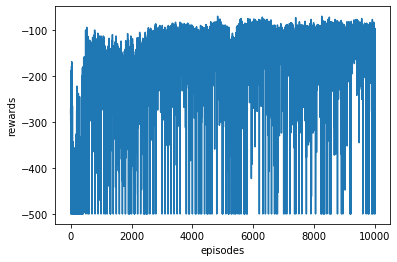

In [6]:
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.xlabel('episodes')
plt.ylabel('rewards')

In [7]:
avg_reward = []
index = []
sum_ = 0
for i in range(len(rewards)):
    if(i%100 == 0):
        avg_reward.append(sum_/100)
        index.append(i+1)
        sum_ = 0
    sum_+=rewards[i]
avg_reward.append(sum_/100)
index.append(i+1)

Text(0, 0.5, 'rewards')

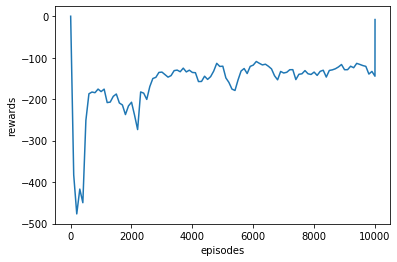

In [8]:
plt.plot(index,avg_reward)
plt.xlabel('episodes')
plt.ylabel('rewards')